## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from random import sample
import sklearn.model_selection
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, average_precision_score
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
24288,00006383_001.png,No Finding,1,6383,40,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00006383_001.png
70238,00017307_000.png,Fibrosis|Infiltration|Mass|Nodule,0,17307,51,M,PA,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017307_000.png
71917,00017714_037.png,No Finding,37,17714,19,M,AP,3040,2544,0.139,0.139,NaN,/data/images_008/images/00017714_037.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
# how many labels

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2022,00000517_002.png,No Finding,2,517,64,F,PA,2498,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10634,00002756_008.png,No Finding,8,2756,66,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47682,00012093_006.png,Atelectasis|Effusion,6,12093,44,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']

In [5]:
print(all_xray_df.shape)
all_xray_df['pneumonia_class'].value_counts()
print(all_xray_df['pneumonia_class'].sum()/len(all_xray_df))

(112120, 29)
0.012763110952550838


## Create your training and testing data:

In [6]:
def create_splits(df, split):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_df, valid_df = sklearn.model_selection.train_test_split(df, 
                                   test_size = split, 
                                   stratify = df['pneumonia_class'])
    p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
    np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_df.loc[p_inds + np_sample]
    
    p_inds = valid_df[valid_df.pneumonia_class==1].index.tolist()
    np_inds = valid_df[valid_df.pneumonia_class==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 5 times as big as the pneumonia sample.
    np_sample = sample(np_inds,(5*len(p_inds)))
    val_data = valid_df.loc[p_inds + np_sample]
    
    return train_data, val_data

In [7]:


train_data, val_data = create_splits(all_xray_df, split=0.2)

# Check the classes are balanced in the train set and validation set\
print(train_data['pneumonia_class'].sum()/len(train_data))
print(val_data['pneumonia_class'].sum()/len(val_data))


0.5
0.16666666666666666


In [8]:
train_data.shape

(2290, 29)

In [11]:
val_data['Finding Labels'].value_counts()[0:20]

No Finding                      792
Infiltration                    129
Pneumonia                        66
Effusion                         47
Atelectasis                      46
Infiltration|Pneumonia           39
Pneumothorax                     36
Edema|Infiltration|Pneumonia     29
Nodule                           27
Mass                             26
Effusion|Infiltration            25
Atelectasis|Pneumonia            25
Consolidation                    18
Cardiomegaly                     18
Effusion|Pneumonia               14
Edema|Pneumonia                  13
Pleural_Thickening               13
Emphysema                        12
Infiltration|Nodule              11
Cardiomegaly|Effusion            11
Name: Finding Labels, dtype: int64

In [9]:
val_data.shape

(1716, 29)

In [10]:
val_data['pneumonia_class'].value_counts()

0.0    1430
1.0     286
Name: pneumonia_class, dtype: int64

In [11]:
train_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
85960,00021201_070.png,Atelectasis|Edema|Infiltration|Pneumonia,70,21201,66,M,AP,3056,2536,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
46264,00011831_015.png,Edema|Emphysema|Infiltration|Mass|Pneumonia,15,11831,56,F,PA,2658,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
18629,00004937_000.png,Atelectasis|Pneumonia,0,4937,68,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
83012,00020405_030.png,Pneumonia,30,20405,49,M,AP,2788,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8874,00002343_003.png,Effusion|Pneumonia,3,2343,31,F,PA,2682,2318,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
train_data['pneumonia_class'] = train_data['pneumonia_class'].apply(lambda x: str(x))
val_data['pneumonia_class'] = val_data['pneumonia_class'].apply(lambda x: str(x))

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
IMG_SIZE = (224, 224)

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range = 0.1,
                                  zoom_range=0.1) 
    
    return my_idg

def make_train_gen(train_df,my_train_idg, BATCH_SIZE):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 32
                                         )
     # Todo

    return train_gen


def make_val_gen(val_data, my_val_idg, BATCH_SIZE):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = 32) 
    
    # Todo
    return val_gen


In [14]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1) 

train_gen = make_train_gen(train_data,idg,len(train_data))
my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
val_gen = make_val_gen(val_data,my_val_idg, len(val_data))


Found 2290 validated image filenames belonging to 2 classes.
Found 1716 validated image filenames belonging to 2 classes.


In [104]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

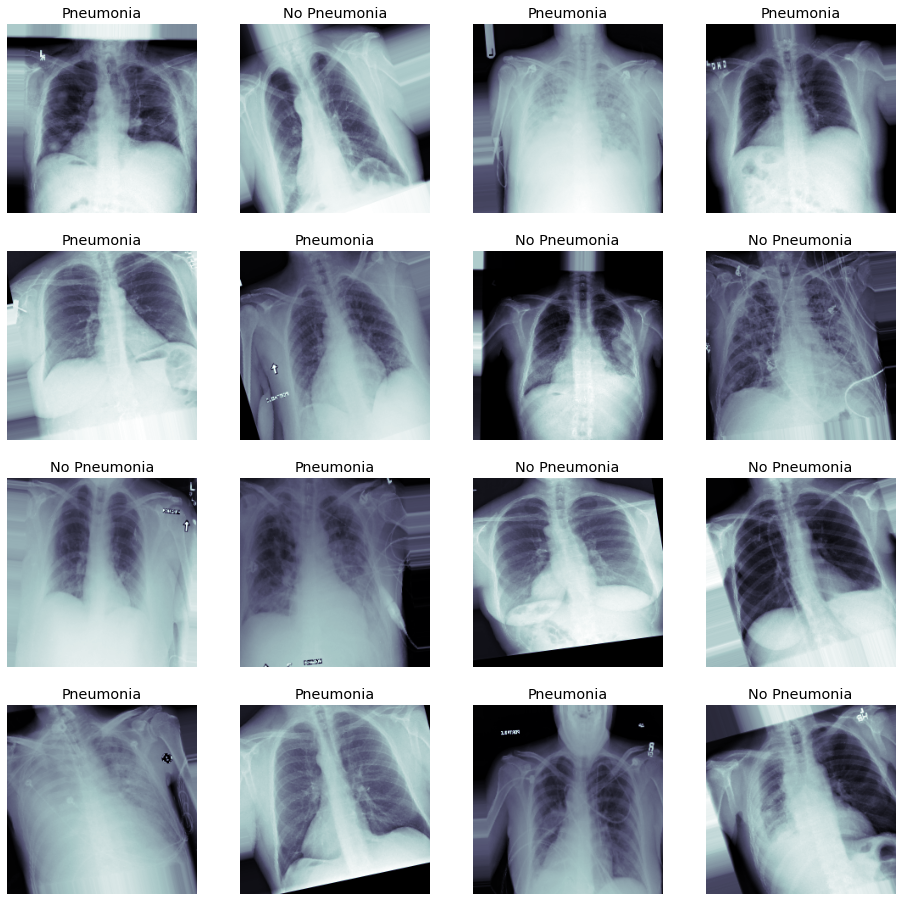

In [105]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [106]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model
vgg_model = load_pretrained_model('block5_pool')
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [111]:
def build_my_model(vggmodel):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    my_model.add(vggmodel)
    # Flatten the output of the VGG16 model
    my_model.add(Flatten())
    
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))


    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(1, activation='sigmoid'))
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=0.7e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [112]:
my_model = build_my_model(vgg_model)
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [113]:
# Below is some helper code that will allow you to add checkpoints to your model,
# This will save the 'best' version of your model by comparing it to previous epochs of training

# Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
# The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
# improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [114]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 12, 
                          callbacks = callbacks_list)

Epoch 1/12
72/72 [==============================] - 60s 830ms/step - loss: 0.7739 - binary_accuracy: 0.5188 - val_loss: 0.7038 - val_binary_accuracy: 0.4375

Epoch 00001: val_loss improved from inf to 0.70384, saving model to xray_class_my_model.best.hdf5
Epoch 2/12
72/72 [==============================] - 60s 827ms/step - loss: 0.7177 - binary_accuracy: 0.5218 - val_loss: 0.7125 - val_binary_accuracy: 0.4375

Epoch 00002: val_loss did not improve from 0.70384
Epoch 3/12
72/72 [==============================] - 59s 826ms/step - loss: 0.6952 - binary_accuracy: 0.5328 - val_loss: 0.6602 - val_binary_accuracy: 0.6562

Epoch 00003: val_loss improved from 0.70384 to 0.66016, saving model to xray_class_my_model.best.hdf5
Epoch 4/12
72/72 [==============================] - 60s 829ms/step - loss: 0.6962 - binary_accuracy: 0.5537 - val_loss: 0.6689 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss did not improve from 0.66016
Epoch 5/12
72/72 [==============================] - 60s 831ms/step

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [123]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 10ms/step


In [124]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    

## what other performance statistics do you want to include here besides AUC? 

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)  



#Also consider plotting the history of your model training:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


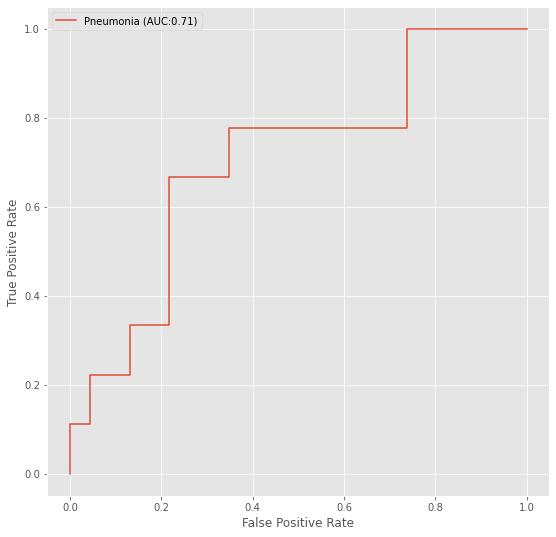

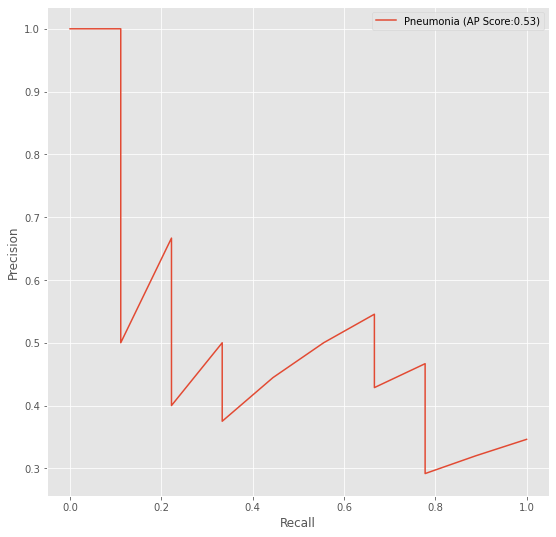

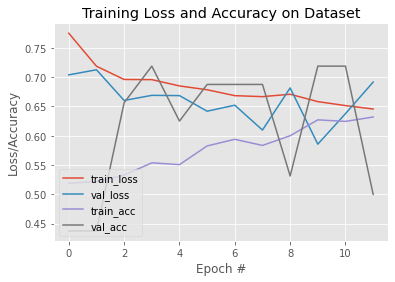

In [125]:
## plot figures
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_history(history)

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [132]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx-1]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))



Precision is: 0.6666666666666666
Recall is: 0.2222222222222222
Threshold is: 0.5803399
F1 Score is: 0.3333333333333333
Precision is: 0.2916666666666667
Recall is: 0.7777777777777778
Threshold is: 0.31877157
F1 Score is: 0.42424242424242425


20

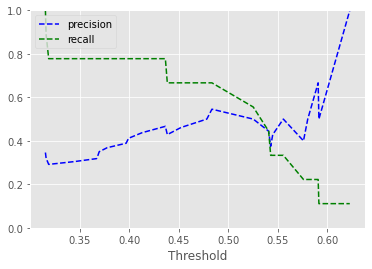

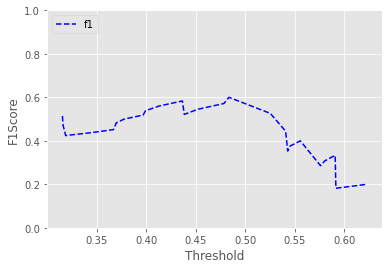

In [135]:
# Precision Recall vs Threshold 
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
f1 = calc_f1(precision,recall)
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(precision, recall, thresholds)
plt.show()

def plot_f1_vs_tresh(f1, thresholds):
    plt.plot(thresholds, f1[:-1], 'b--', label='f1')
    plt.ylabel('F1Score')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_f1_vs_tresh(f1, thresholds)
plt.show()

 Based on the above plots i am going to take a threshold of 0.43. I want to optimize recall because that is important for screening tests. We want a low number of false negatives. 

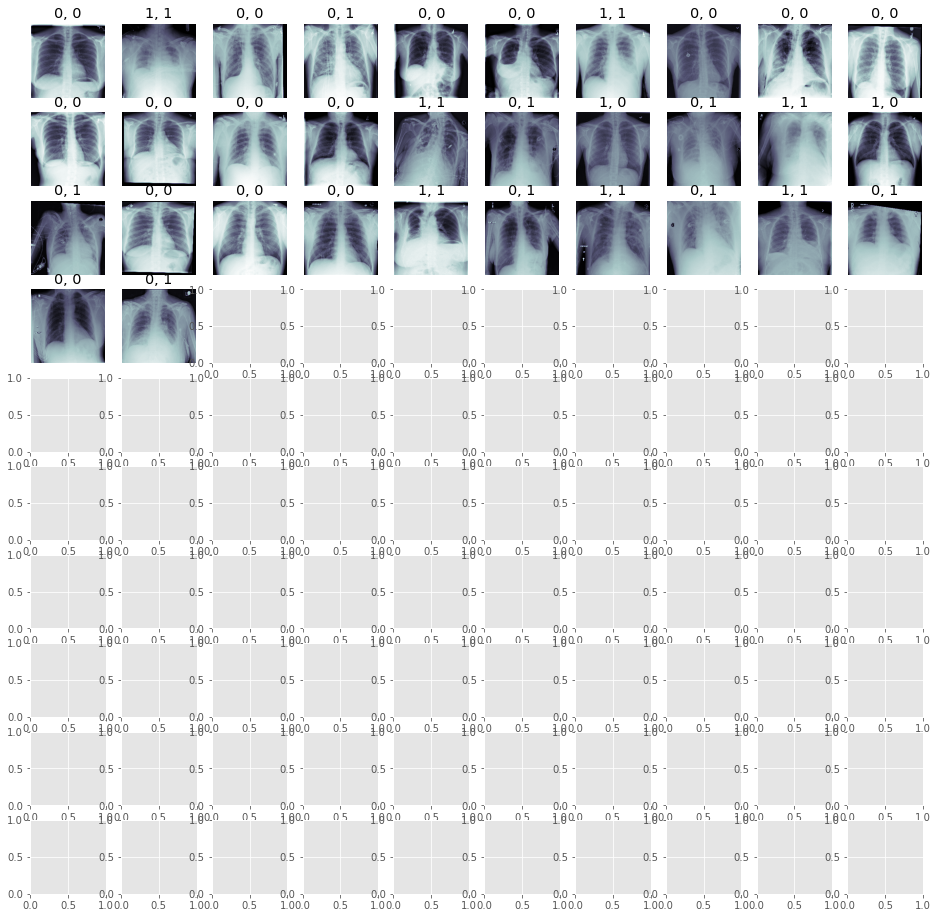

In [136]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.43:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.43: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [138]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)